## Calibration Workshop

In this Notebook we will:
- Load data and train a model
- Assess the Calibration of the model
- Explore various methods to calibrate the results of the model

Notebook requires `numpy`, `pandas`, `scikit-learn` as well as the `ml-insights` and `betacal` packages

In [1]:
# !pip install ml_insights
# !pip install betacal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import betacal as bc
from betacal import BetaCalibration
mli.__version__, bc.__version__

('1.0.4', '1.1.0')

### MIMIC ICU Data*

We illustrate calibration using a mortality model on the MIMIC ICU data.  Each row represents a hospital stay of an individual patient.  We have many lab values and vital sign measurements, as well as an indicator of whether or not the patient died in the hospital.

*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016).
https://mimic.physionet.org

In [2]:
# Load dataset from local (cloned repo)
#lab_aug_df = pd.read_csv("../GBIP/data/lab_vital_icu_table.csv")

# Load dataset from Github (if using colab)
lab_aug_df = pd.read_csv("https://raw.githubusercontent.com/numeristical/resources/refs/heads/master/GBIP/data/lab_vital_icu_table.csv")


In [3]:
# Impute the median for in each column to replace NA's 
for i in range(len(lab_aug_df.columns)):
    if lab_aug_df.iloc[:,i].dtype!='O':
        lab_aug_df.iloc[:,i].fillna(lab_aug_df.iloc[:,i].median(),inplace=True)

/var/folders/hr/j55bgxq50576_rkv4m06b6zm0000gn/T/ipykernel_94545/4204442802.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lab_aug_df.iloc[:,i].fillna(lab_aug_df.iloc[:,i].median(),inplace=True)
/var/folders/hr/j55bgxq50576_rkv4m06b6zm0000gn/T/ipykernel_94545/4204442802.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

## Lesson 1: Assessing Calibration

We will be building a model to predict mortality in the ICU based on vital signs and lab values.  To start, we will just pick a few different ones on which to build our model.

In [4]:
# Choose a subset of variables
feature_set_1 = ['bun_min',
       'bun_max', 'wbc_min', 'wbc_max','sysbp_max', 'sysbp_min']

X_1 = lab_aug_df.loc[:,feature_set_1]
y = lab_aug_df['hospital_expire_flag']

We now divide the data into training, calibration, and test sets.  The training set will be used to fit the model, the calibration set will be used to calibrate the probabilities, and the test set will be used to evaluate the performance. Later, we will learn about cross-validation approaches that avoid the need for a separate calibration set.

Below are the variables used to control the size of the train, calibration, and test sets, as well as the random state used for split generation *and* random forest model generation.

Note that there will be a lot of variance in the performance of the methods as we change these parameters.  Therefore it is important not to draw overly broad conclusions from individual runs.  At the end of this notebook will be an exercise to change these parameters around and observe the variation.

In [5]:
train_perc = .6
calib_perc = .05
test_perc = 1-train_perc-calib_perc
rs = 42

In [6]:
X_train_calib_1, X_test_1, y_train_calib_1, y_test_1 = train_test_split(X_1, y, test_size=test_perc, random_state=rs)

In [7]:
X_train_1, X_calib_1, y_train_1, y_calib_1 = train_test_split(X_train_calib_1, y_train_calib_1, 
                                                              test_size=calib_perc/(1-test_perc), 
                                                              random_state=rs)

In [8]:
X_train_1.shape, X_calib_1.shape, X_test_1.shape

((35834, 6), (2987, 6), (20905, 6))

In [9]:
# To understand the problem better, let's see what percentage of patients overall died in the ICU
np.mean(y_train_1)

0.1092537813249986

Next, we will fit a Random Forest model to our training data.  Then we'll use that model to predict "probabilities" on our validation and test sets.  

I use quotes on "probabilities" because these numbers, which are the percentage of trees that voted "yes" are better understood as mere scores.  A higher value should generally indicate a higher probability of mortality.  However, in general, one should not expect these to be well-calibrated probabilities.  The fact that, say, 60% of the trees voted "yes" on a particular case does not necessarily mean that that case has a 60% probability of mortality.


In [10]:
rfmodel1 = RandomForestClassifier(n_estimators = 500, class_weight='balanced_subsample', 
                                  random_state=rs, n_jobs=-1 )
rfmodel1.fit(X_train_1,y_train_1)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1, random_state=42)

In [11]:
rf1_preds_test_uncalib = rfmodel1.predict_proba(X_test_1)[:,1]

## Assessing Calibration: 

Our approach to calibration will focus on the ultimate performance of the calibrated model on the independent test set.  To determine if our calibration was 


### Log-loss (aka Cross-Entropy aka Negative Mean Log-Likelihood)
- The `log_loss` is a common metric to measure the "quality" of predicted probabilities
- AUROC measures the quality of the **ranking** but does not assess **calibration**
- `log_loss` assesses the combination of discrimination and calibration.
- `log_loss` is difficult to interpret on its own, generally used comparatively.

$
\begin{equation}
 log\_loss = \frac{1}{n} \left(\sum_{\mbox{pos cases}} -log(p_i) + \sum_{\mbox{neg cases}} -log(1- p_i)\right)
\end{equation}
$

- If you predicted a probability of .25 for a case, and it happened, your loss for that case would be $-\log(.25) = \log(1/.25) = \log(4)$
- If you predicted a probability of .8 for a case, and it *didn't* happen, your loss for that case would be $-\log(1-.8) = \log(1/.2) = \log(5)$
- Loss is 0 when you are certain about the outcome and you are right
- Loss is $\infty$ when you are certain about the outcome and you are wrong

In [12]:
roc_auc_score(y_test_1, rf1_preds_test_uncalib), log_loss(y_test_1, rf1_preds_test_uncalib)

(0.7658033335379734, 0.3124065935918772)

In [13]:
# If I divide all probabilities by 4, AUROC is the same, but log_loss gets worse
roc_auc_score(y_test_1, rf1_preds_test_uncalib/4), log_loss(y_test_1, rf1_preds_test_uncalib/4)

(0.7658033335379734, 0.38787883656948247)

## Assessing Calibration: Brier Score
$\begin{equation}
Brier\_Score = \frac{1}{n} \left(\sum_{\mbox{all cases}} (y_i-p_i)^2 \right)
\end{equation}$

Brier score is a fancy name for the mean squared error between the predicted probabilities and the true (0/1) answer.  If I predict .7 on a case that was true (1), my error for that case is $(1-.7)^2 = .09$

Average the scores on all cases, and that gives the Brier score.

Note that the "worst case" for Brier score is 1, whereas for log-loss it is $\infty$.

In [14]:
brier_score_loss(y_test_1, rf1_preds_test_uncalib)

0.0848498497268394

### Log-loss vs Brier Score

The main difference between Brier score and log-loss is how they deal with small probabilities.  Suppose the "true" probability is .01 and you predict a probability of .0001, is that a "big" error?

According to log-loss, it is.  You have understated the true probability by a factor of 100.  If you were working in insurance, and predicting the probability of a car accident, the insurance company would be paying out 100x as much as they thought they would.

According to Brier score, it is not that a big deal.  For some applications, that may be appropriate.  For example, if you are modeling the probability someone will vote for Candidate A vs Candidate B, and planning to use that model to estimate election results on some population, it doesn't matter to distinguish between very low probabilities.

This is actually a very "deep" topic.  We will focus primarily on the log-loss, but will also show the results on Brier score.

Both Brier score and log-loss are "proper" scoring rules, meaning that the "truth" should give a better value (in the long run) than any other "incorrect" answer.  This may seem obvious or redundant, but there are lots of metrics which seem reasonable and are used in practice which are not proper.  (For example, if you replace the "squaring" in the Brier score with absolute value, the resulting metric is not proper.)



## Assessing Calibration: Reliability Diagram
A visual way to check the calibration of a model is to create a "Reliability Diagram".  The idea behind the reliability diagram is the following:
- Bin the interval [0,1] into smaller subsets (e.g. [0, 0.05], [0.05, .1], ... [.95,1])
- Find the empirical probabilities when the probabilities fell into each bin  (if there were 20 times, and 9 of them were "yes", the empirical probability is .45)
- Plot the predicted probability (average of predicted probabilities in each bin) (x-axis) vs the empirical probabilities(y-axis)
- When the dots are (significantly) above the line y=x, the model is under-predicting the true probability, if below the line, model is over-predicting the true probability.

<br>

We will use the ml-insights `plot_reliability_diagram` function.  It has a fair bit of flexibility that we will explore.
Some features include:
- custom bins
- accompanying histogram
- error bars
- logit scaling to explore calibration of very small and very large probabilities

In [15]:
mli.plot_reliability_diagram?

Signature:
mli.plot_reliability_diagram(
    y,
    x,
    bins=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
    show_baseline=True,
    baseline_color='black',
    baseline_width=1,
    error_bars=True,
    error_bar_color='C0',
    error_bar_alpha=0.05,
    error_bar_width=2,
    ci_ref='axis',
    marker='.',
    marker_color='C1',
    marker_edge_color='C1',
    marker_size=50,
    scaling='none',
    scaling_eps=0.0001,
    scaling_base=10,
    cap_width=1,
    cap_size=5,
    show_histogram=False,
    bin_color='C0',
    bin_edge_color='black',
    ax1_x_title='Predicted',
    ax1_y_title='Empirical',
    ax2_x_title='Predicted Scores',
    ax2_y_title='Count',
    ax_title_weight='normal',
    ax_title_size=12,
    title_size=16,
    title_weight='normal',
    reliability_title='Reliability Diagram',
    histogram_title='Probability Distribution',
    layout_pad=3.0,
    legend_names

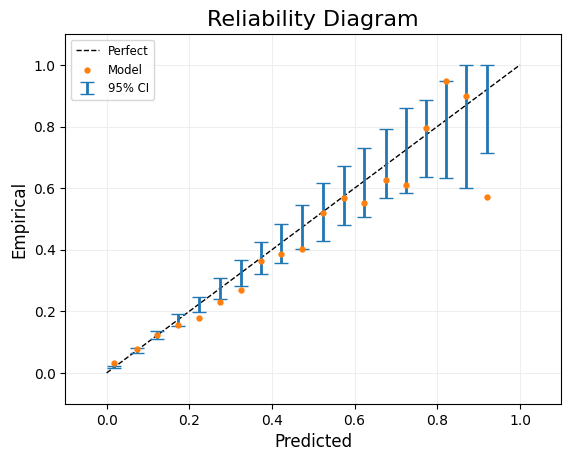

In [16]:
# This is the default plot
rd = mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib);

Above we see the default reliability diagram.  While most of the points seem to be within the error bars there are a couple of flaws to point out:
1. Between about .2 and .45 we are consistently over-predicting the mortality.  Though they are right on the edge of the error bar, having many in a row with errors in the same direction indicates this is not random noise.
1. It is hard to see the smaller probabilities well (in the first two bins), but they look like they may be under-predicting.  We will demonstrate how to explore this better

First we will explore some options in the `plot_reliability_diagram` function

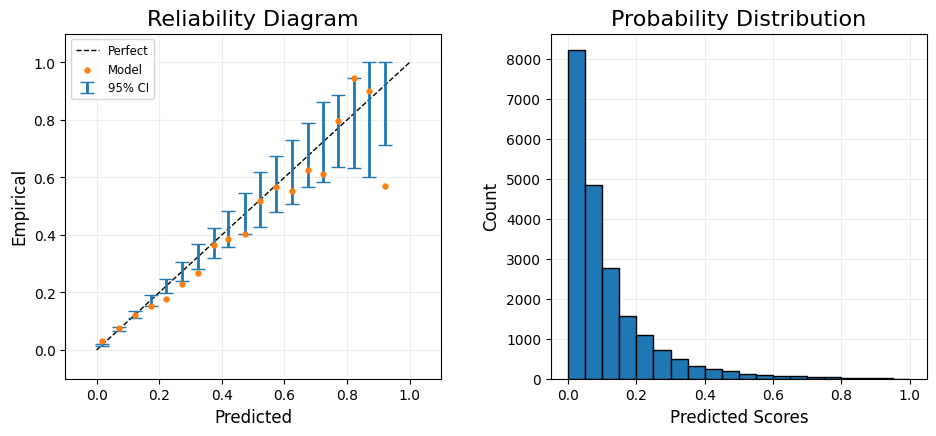

In [17]:
# You can opt to have a histogram showing the counts in each bin
plt.figure(figsize=(10,5))
mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib, show_histogram=True);

We see that we have lots of observations with small predicted probabilities and fewer with large probabilities.  Suppose we want to subdivide further the bins where we have lots of data, and aggregate the bins that have less data.

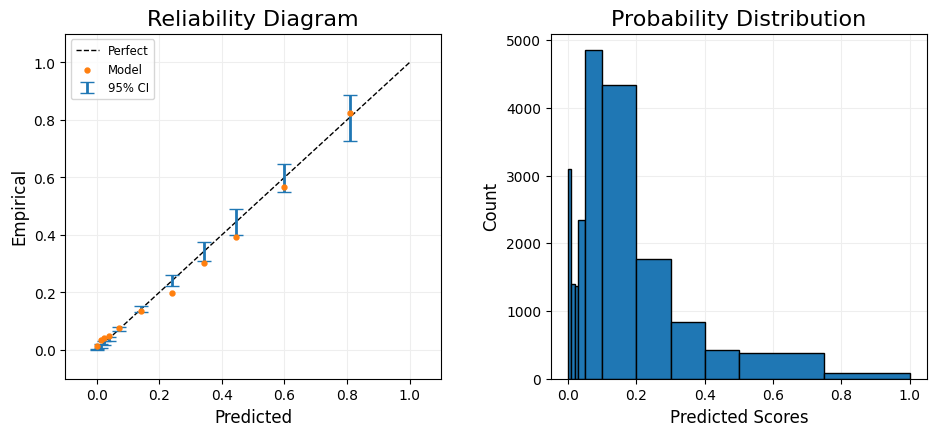

In [18]:
plt.figure(figsize=(10,5))
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .2, .3, .4, .5, .75, 1])
mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib, bins=custom_bins_a, show_histogram=True);

Looks like we are over-predicting the probability between .2 and .4.  Also, we may be underpredicting close to 0, but it is hard to tell.  To look closer, we can use the "logit" scaling.  This scaling uses more area at probabilities close to 0 and 1, and less area close to .5

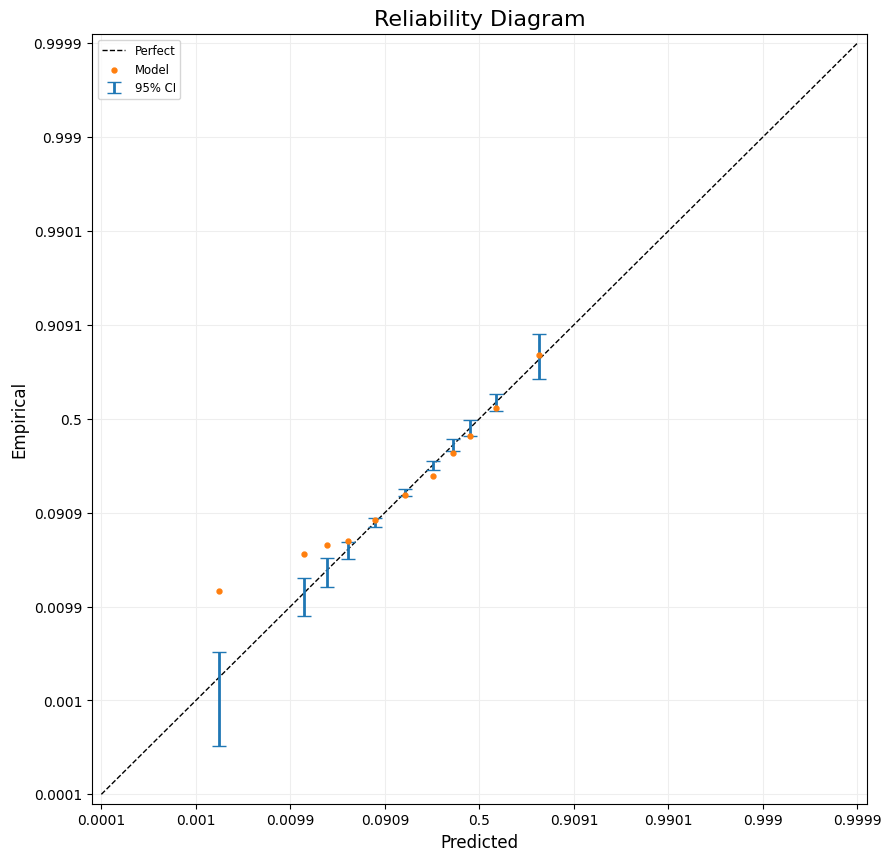

In [19]:
plt.figure(figsize=(10,10))
rd = mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib, scaling='logit',
                                 bins=custom_bins_a, marker='.')

(-4.0, 0.0)

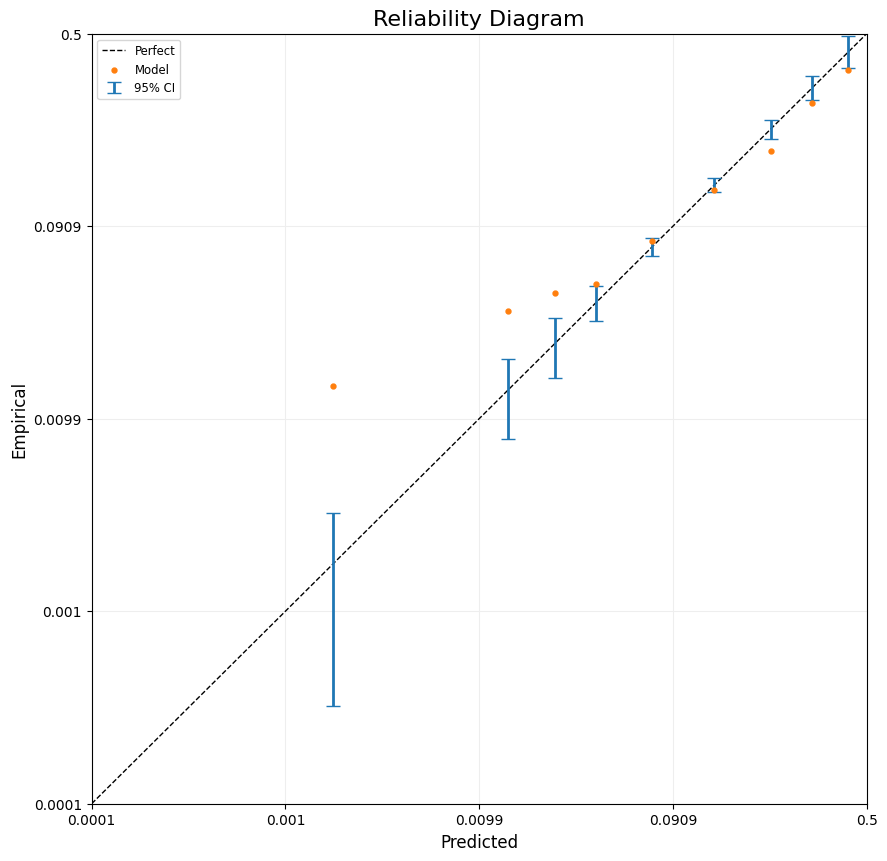

In [20]:
# Let's zoom in to the lower left corner
plt.figure(figsize=(10,10))
rd = mli.plot_reliability_diagram(y_test_1, rf1_preds_test_uncalib, scaling='logit',
                                 bins=custom_bins_a, marker='.')
plt.xlim([-4,0]) # on logit scale...
plt.ylim([-4,0])

Now we are able to see that we are underpredicting at low probabilities and then overpredicting around .3.  Let's extract a few numbers by looking at the dictionary `rd` returned by the function

In [21]:
rd.keys()

dict_keys(['pred_probs', 'emp_probs', 'bin_counts'])

In [22]:
rd['pred_probs'], rd['emp_probs'], rd['bin_counts']

(array([0.00174848, 0.01386466, 0.02392326, 0.03875399, 0.07237641,
        0.14084658, 0.24184906, 0.34315092, 0.44412095, 0.5995489 ,
        0.8094    ]),
 array([0.01454428, 0.03487544, 0.04309715, 0.04767986, 0.07727179,
        0.13393269, 0.19830508, 0.30382775, 0.39344262, 0.56510417,
        0.825     ]),
 array([3094., 1405., 1369., 2349., 4853., 4338., 1770.,  836.,  427.,
         384.,   80.]))

Here we can see clearly that for the smallest bin, we have an average predicted probability of about .0017 but empirically (on 3104 trials) we have a probability of .012 -- off by a factor of 7!

In [23]:
.012/.0017

7.058823529411765

#### sklearn `calibration_curve`
- Scikit-learn has a function `calibration_curve` that will give the x and y coordinates for a number of bins.
- The rest of the plotting is up to you
- It does not support custom bin widths (October 2023, v1.3.2)

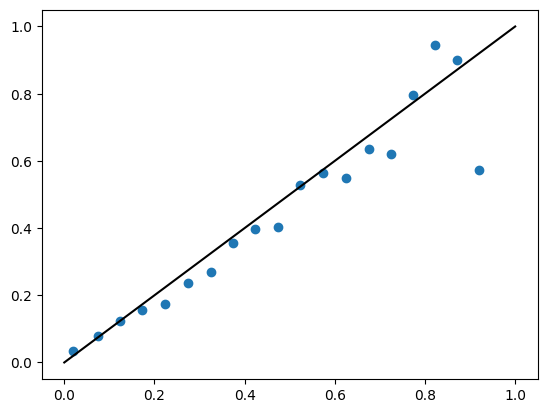

In [24]:
prob_true, prob_pred = calibration_curve(y_test_1, rf1_preds_test_uncalib, n_bins=20)
plt.scatter(prob_pred, prob_true)
plt.plot(np.linspace(0,1,11),np.linspace(0,1,11), color='k')

## Expected Calibration Error
In the literature on calibration, you may see references to the Expected Calibration Error.  This metric attempts to numerically measure the quality of a calibration by using the bins, as in the Reliability Diagram.  Given $k$ bins as above, the $ECE$ is defined by:

$ECE = \sum_{i=1}^k \frac{n_i}{n}|o_i - e_i|$

where $n$ is the total number of data points, $n_i$ is the number in each bin, $o_i$ is the "observed" probability in the bin and $e_i$ is the "expected" (i.e. predicted) probability in each bin.  Essentially, you average the distances from the line $y=x$ in the reliability diagram, giving proportionally more weight to the bins with more data.

However, $ECE$ has numerous shortcomings (see Nixon et al. Measuring Calibration in Deep Learning as a reference), including the fact that it depends on the choice of bins.  I strongly believe that a more representative metric is to compare different models by how they behave on the actual test set, using a proper scoring rule.

<br>

## Exercise
### It's your turn!
Repeat this process for a bigger set of features below

In [25]:
# Choose a subset of variables

# feature_set_2 = feature_set_1 + ['lactate_min', 'lactate_max', 'platelet_min', 'platelet_max',
#        'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min',
#        'inr_max']

In [26]:
# Repeat train, calib, test split

# X_2 = lab_aug_df.loc[:,feature_set_2]
# X_train_calib_2, X_test_2, y_train_calib_2, y_test_2 = train_test_split(X_2, y, test_size=test_perc, random_state=rs)
# X_train_2, X_calib_2, y_train_2, y_calib_2 = train_test_split(X_train_calib_2, y_train_calib_2, 
#                                                               test_size=calib_perc/(1-test_perc), 
#                                                               random_state=rs)

In [27]:
# Fit a Random Forest Model

# rfmodel2 = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', 
#                                   random_state=rs, n_jobs=-1 )
# rfmodel2.fit(X_train_2,y_train_2);

In [28]:
# rf2_preds_test_uncalib = rfmodel2.predict_proba(X_test_2)[:,1]

In [29]:
# roc_auc_score(y_test_2, rf2_preds_test_uncalib), log_loss(y_test_2, rf2_preds_test_uncalib)

Use the cells below to explore the calibration of this model.

- Is it well calibrated?
- How does it compare to the previous model?

In [30]:
# Plot the default reliability diagram
# mli.plot_reliability_diagram();

In [31]:
# Display the histogram on the side

# plt.figure(figsize=(8,4))
# mli.plot_reliability_diagram(...);

In [32]:
# Create a custom set of bins

# bins_custom_b = np.array([])
# mli.plot_reliability_diagram(...);


In [33]:
# Use the logit scaling

# plt.figure(figsize=(10,4))
# mli.plot_reliability_diagram(...);

### Extra Credit: 
Fit another kind of model (Boosting, Logistic Regression, etc.) on the same data set and assess the calibration of that model

## Lesson 2: Calibrating a Model
Since our models are not well-calibrated, we would like to fix this.  

### Getting a **Calibration** Data Set

We will discuss two ways to get a data set on which to perform calibration:

- Use an independent calibration set
- Using Cross-validation to generate scores from the training set.

The first method is simpler, but requires a separate data set, meaning that you will have less data to train your model with.  It is good to use if you have plenty of data.

The second approach takes more time, but is generally more data-efficient.  We generate a set of cross-validated predictions on the training data.  These predictions come from models that are close to, but not exactly identical to, your original model.  However, this discrepancy is usually minor and offset by having more data on which to calibrate.

### Method of Calibration

The data set for calibration is a set of scores and the corresponding binary outcomes.  The goal is then to find a function that "fits" the relationship between the scores and the "actual" probabilities (as determined empirically in the calibration set.  We will review 4 methods of calibration:

- Platt Scaling
- Beta Calibration
- Isotonic Regression
- SplineCalib


## Approach A: Independent calibration set
Overall process: 
- Need separate training and calibration sets (plus a test set to evaluate)
- Fit model on training set data
- Make predictions on calibration set.
- Use those predictions + true answers to fit a calibration object.
- Use model to make predictions on test set
- Use calibrator to calibrate those predictions
- Evaluate log_loss, reliability diagram on calibrated predictions


In [34]:
calibset_preds_uncalib_1 = rfmodel1.predict_proba(X_calib_1)[:,1]
testset_preds_uncalib_1 = rfmodel1.predict_proba(X_test_1)[:,1]

## Method 1: Platt Scaling
Assumes that there is a logistic relationship between the scores $z$ and the true probability $p$.

$\log\left(\frac{p}{1-p}\right) = \alpha + \beta z$

$p = \frac{1}{1+\exp(-(\alpha + \beta z))}$

So it fits the two parameters $\alpha$ and $\beta$ just like in logistic regression!

- Very restrictive set of possible functions
- Needs very little data
- Historically, came from the observation (and subsequent theoretical arguments) that a logistic regression was the "right" calibration for Support Vector Machines

Reference: Platt, J. (1999). Probabilistic outputs for support vector machines and comparison to regularized likelihood methods. Advances in Large Margin Classifiers (pp.61–74).

In [35]:
# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=np.inf, solver='lbfgs')
lr.fit(calibset_preds_uncalib_1.reshape(-1,1), y_calib_1)


LogisticRegression(C=inf)

In [36]:
calibset_platt_probs = lr.predict_proba(calibset_preds_uncalib_1.reshape(-1,1))[:,1]
testset_platt_probs = lr.predict_proba(testset_preds_uncalib_1.reshape(-1,1))[:,1]

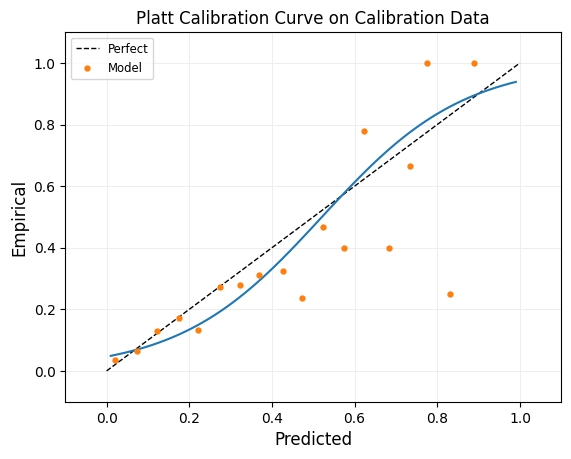

In [37]:
mli.plot_reliability_diagram(y_calib_1, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1]);
plt.title('Platt Calibration Curve on Calibration Data');

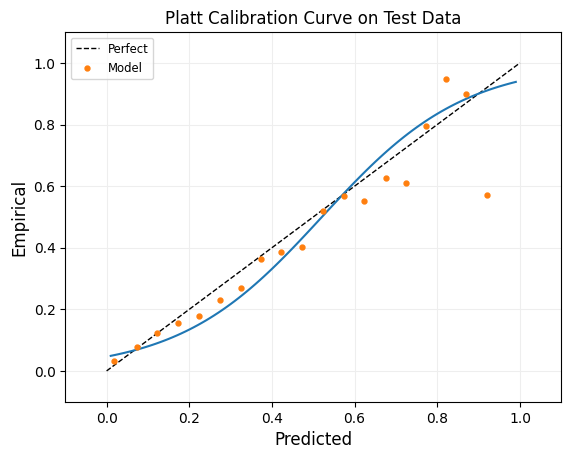

In [38]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1])
plt.title('Platt Calibration Curve on Test Data');

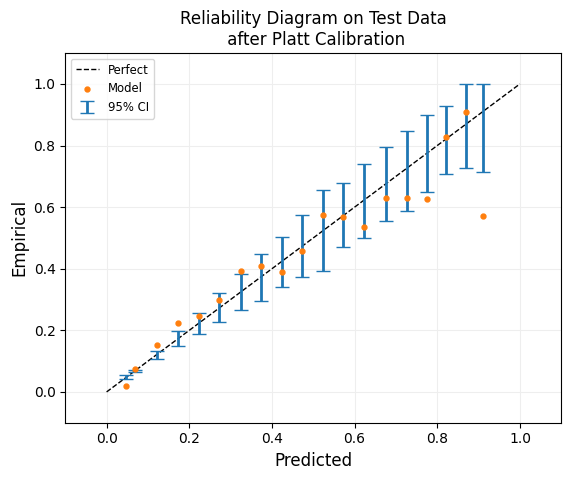

In [39]:
mli.plot_reliability_diagram(y_test_1, testset_platt_probs);
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

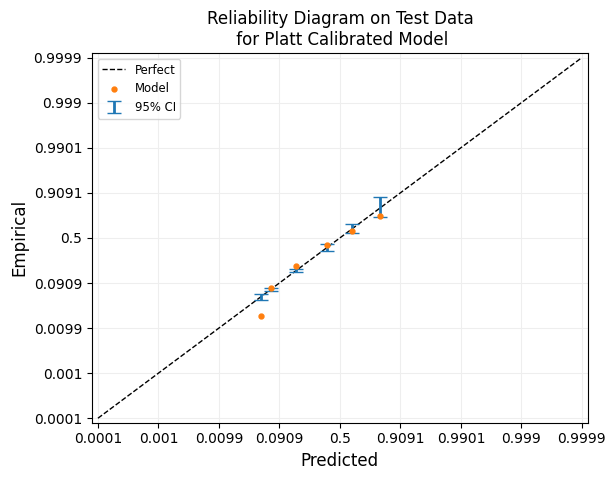

In [40]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_platt_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Platt Calibrated Model');

Using the logit scaling, we can see that the calibration does poorly at the small values.

In [41]:
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Platt calibrated log_loss = 0.2980150581830061
Uncalibrated log_loss = 0.3124065935918772


Despite this, we see an improvement in log_loss.  Generally, making mistakes by predicting "closer to .5" is better for log loss (i.e. better to overpredict rare events and underpredict near certain events)

## Method 2: Isotonic Regression
- Fits a piecewise constant, monotonically increasing, function to map the scores to probabilities.
- Uses the PAV (Pool Adjacent Violators, also called PAVA) algorithm.
- Does not assume a particular parametric form.
- Tends to be better than Platt scaling with enough data
- Tends to overfit: ("choppy" with unrealistic jumps)

Reference: Zadrozny,  B., & Elkan, C.(2001). Obtaining calibrated probability estimates from decision trees and naive bayesian classifiers. ICML (pp.609–616).

Zadrozny,  B., & Elkan, C. (2002). Transforming classifier scores into accurate multiclass probability estimates. KDD (pp.694–699).

In [42]:
iso = IsotonicRegression(out_of_bounds = 'clip')
iso.fit(calibset_preds_uncalib_1, y_calib_1)

IsotonicRegression(out_of_bounds='clip')

In [43]:
calibset_iso_probs = iso.predict(calibset_preds_uncalib_1)
testset_iso_probs = iso.predict(testset_preds_uncalib_1)

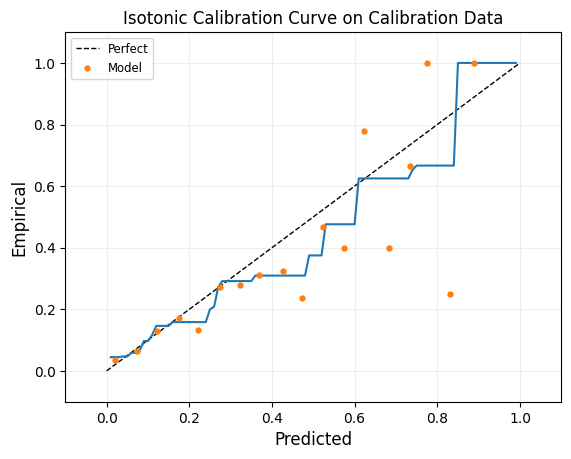

In [44]:
mli.plot_reliability_diagram(y_calib_1, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic');
plt.title('Isotonic Calibration Curve on Calibration Data');

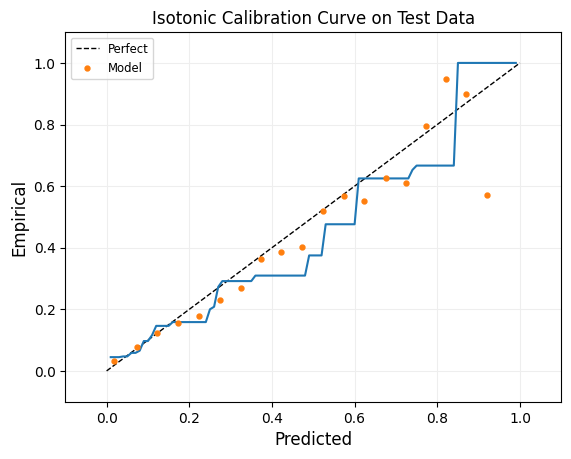

In [45]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic');
plt.title('Isotonic Calibration Curve on Test Data');

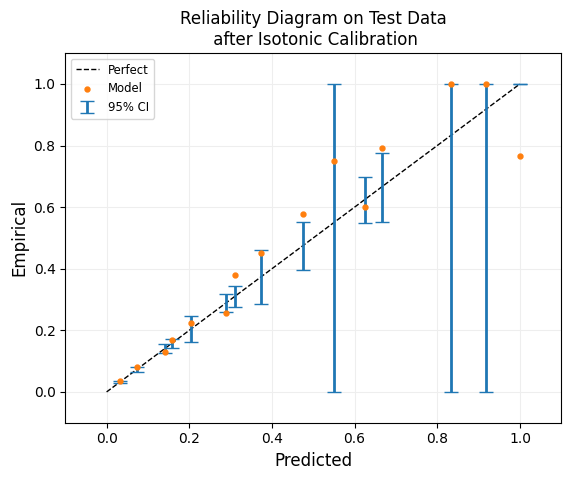

In [46]:
mli.plot_reliability_diagram(y_test_1, testset_iso_probs);
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration');

Here we see some of the artifacts of isotonic calibration.  Some bins have few to no points after calibration due to the vertical "steps" in the function.

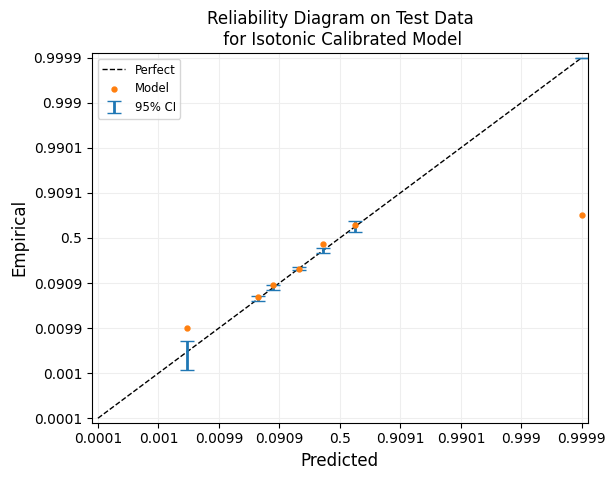

In [47]:
custom_bins_a = np.array([0,.01,.05, .1, .3, .5,  1])
rd = mli.plot_reliability_diagram(y_test_1, testset_iso_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Isotonic Calibrated Model');

In [48]:
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Isotonic calibrated log_loss = 0.30159475869233476
Platt calibrated log_loss = 0.2980150581830061
Uncalibrated log_loss = 0.3124065935918772


## Method 3: Beta Calibration

"A well-founded and easily implemented improvement on logistic calibration for binary classifiers."

$p = \left(1+ 1 / \left( \exp(c) \frac{z^a}{(1-z)^b} \right) \right)^{-1}$

- Similar to Platt scaling with a couple of important improvements
- Is a 3-parameter family of curves rather than 2-parameter
- Family of curves *includes* the line $y=x$ (so it won't mess it up if it's already calibrated)

Reference: Kull, M., Filho, T.S. & Flach, P.. (2017). Beta calibration: a well-founded and easily implemented improvement on logistic calibration for binary classifiers. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, in PMLR 54:623-631 

In [49]:
# Fit three-parameter beta calibration
bc = BetaCalibration()
bc.fit(calibset_preds_uncalib_1, y_calib_1)

BetaCalibration()

In [50]:
calibset_bc_probs = bc.predict(calibset_preds_uncalib_1)
testset_bc_probs = bc.predict(testset_preds_uncalib_1)


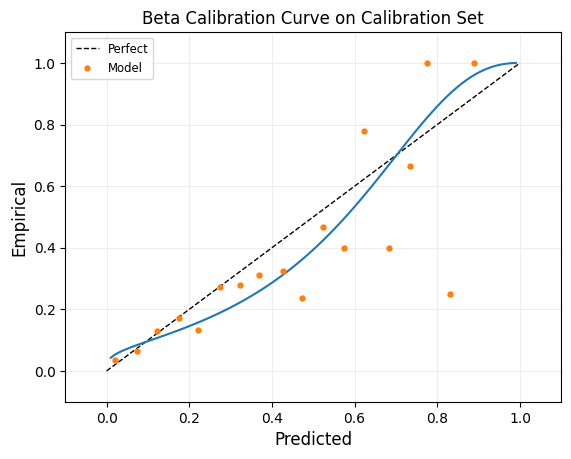

In [51]:
mli.plot_reliability_diagram(y_calib_1, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title('Beta Calibration Curve on Calibration Set');

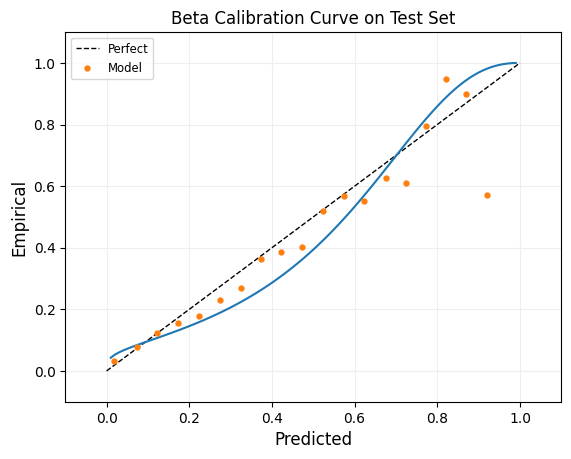

In [52]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title('Beta Calibration Curve on Test Set');

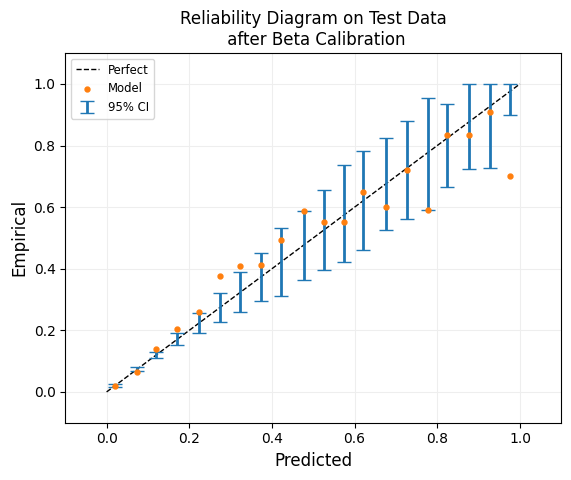

In [53]:
mli.plot_reliability_diagram(y_test_1, testset_bc_probs);
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');

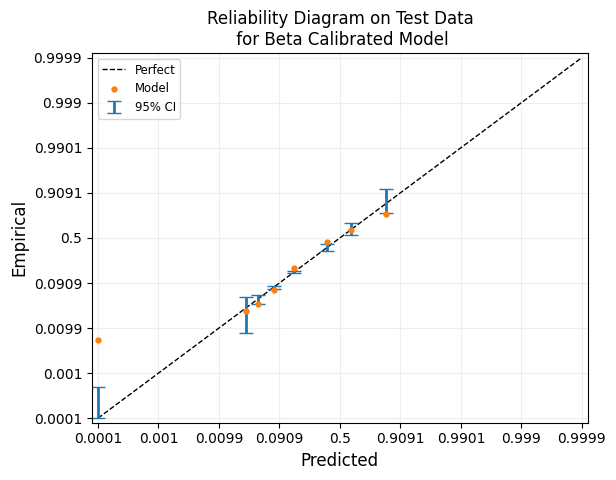

In [54]:
custom_bins_a = np.array([0,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_bc_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Beta Calibrated Model');

In [55]:
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Beta calibrated log_loss = 0.29790615543522936
Isotonic calibrated log_loss = 0.30159475869233476
Platt calibrated log_loss = 0.2980150581830061
Uncalibrated log_loss = 0.3124065935918772


## Method 4: SplineCalib 
- SplineCalib fits a cubic smoothing spline to the relationship between the uncalibrated scores and the calibrated probabilities
- Smoothing splines strike a balance between fitting the points well and having a smooth function (smooth here means a small "integrated second derivative")
- SplineCalib automatically fits the nuisance parameter (though this can be adjusted by the user)
- The resulting calibration function is not necessarily monotonic.  (In some cases this may be beneficial).
- There is some mathematical nuance about whether to transform to log-odds scale before fitting the spline.  By default, this is the behavior, and is recommended (unless you have reason to believe that the uncalibrated scores already have a logistic relationship to the true probabilities).

References: Lucena, B. Spline-based Probability Calibration. https://arxiv.org/abs/1809.07751

In [56]:
# Define SplineCalib object
splinecalib = mli.SplineCalib()
splinecalib.fit(calibset_preds_uncalib_1, y_calib_1)

In [57]:
calibset_splinecalib_probs = splinecalib.predict(calibset_preds_uncalib_1)
testset_splinecalib_probs = splinecalib.predict(testset_preds_uncalib_1)


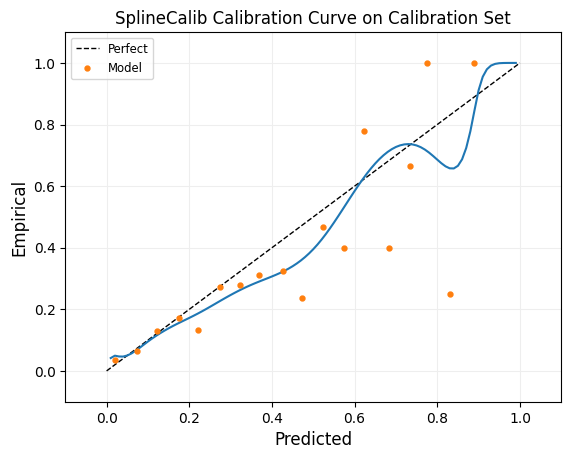

In [58]:
mli.plot_reliability_diagram(y_calib_1, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec))
plt.title('SplineCalib Calibration Curve on Calibration Set');

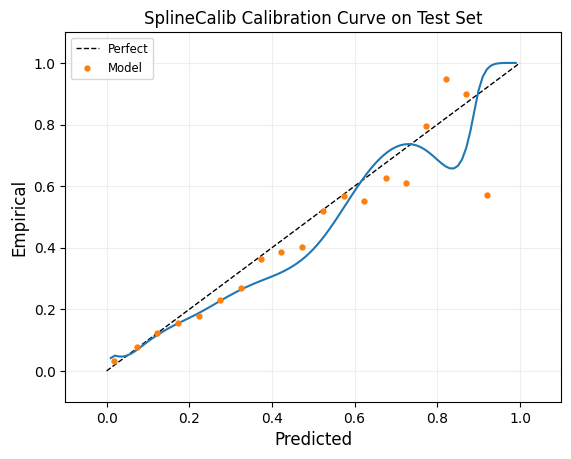

In [59]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec))
plt.title('SplineCalib Calibration Curve on Test Set');

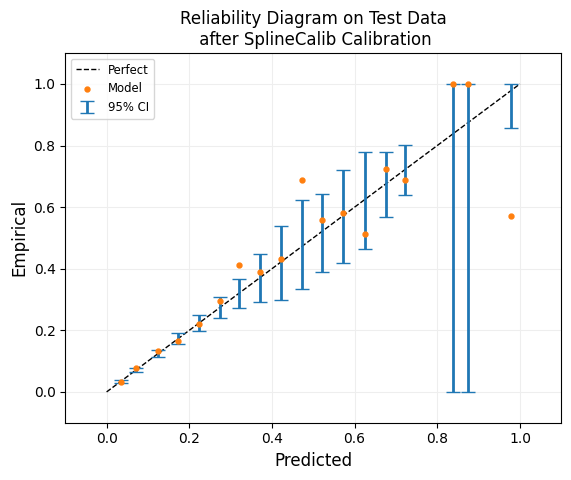

In [60]:
mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs);
plt.title('Reliability Diagram on Test Data\n after SplineCalib Calibration');

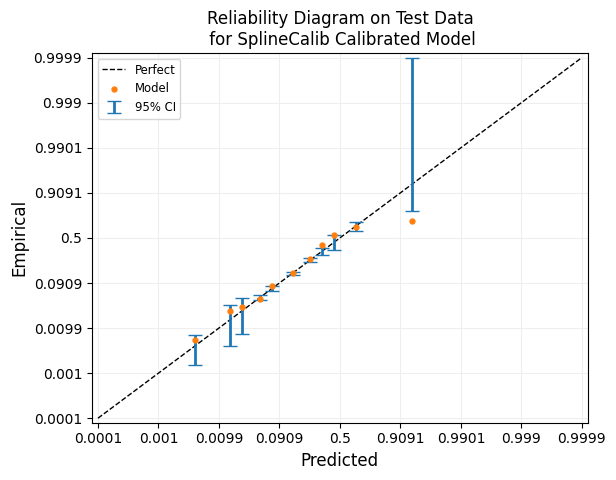

In [61]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1,.2, .3, .4,.5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for SplineCalib Calibrated Model');

In [62]:
print('Spline calibrated log_loss = {}'.format(log_loss(y_test_1, testset_splinecalib_probs)))
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated log_loss = 0.2939691808334008
Beta calibrated log_loss = 0.29790615543522936
Isotonic calibrated log_loss = 0.30159475869233476
Platt calibrated log_loss = 0.2980150581830061
Uncalibrated log_loss = 0.3124065935918772


On this example, SplineCalib does best, though Beta calibration and Platt scaling both do reasonably well (and are quicker to fit).  Isotonic does relatively poorly.  Note that we used only about 3K data points in our calibration set - Isotonic regression is relatively "data-hungry"

Below, we can see the results measured by Brier Score loss.  Note that there may be a very different pattern here in relative performance of the methods.

In [63]:
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_splinecalib_probs)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_bc_probs)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_iso_probs)))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_platt_probs)))
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated Brier Score = 0.08474201737368993
Beta calibrated Brier Score = 0.08498790114463
Isotonic calibrated Brier Score = 0.08489627020738538
Platt calibrated Brier Score = 0.08508499919016266
Uncalibrated Brier Score = 0.0848498497268394


## Your Turn
Calibrate the `rfmodel2` using a couple (or all) of the methods given above.  Compare their performances.  Feel free to cut and paste from above, but try to think about the steps you are doing so it makes sense.

Note that you may get very different results from what happened for `rfmodel1`.

## Approach 2: Cross-validation on the training data
The reason to use an independent calibration set (rather than just the training data) is that how the model performs on the training data (that it has already seen) is not indicative of how it will behave on data it has not seen before.  We want the calibration to correct how the model will behave on "new" data, not the training data.

Another approach is to take a cross-validation approach to generating calibration data.  We divide the training data into k "folds", leave one fold out, train our model (i.e. the choice of model and hyperparameter settings) on the remaining k-1 folds, and then make predictions on the left-out fold.  After doing this process k times, each time leaving out a different fold, we will have a set of predictions, each of which was generated by 1 of k slightly different models, but was always generated by a model that did not see that training point.  Done properly (assuming no "leakage" across the folds), this set of predictions and answers will serve as an appropriate calibration set.

- Advantages: more data for both training *and* calibration.
- Disadvantages: Must train k+1 models.  Also, the calibration data does not come from the exact same model you will be using it on.

ML-Insights (the package containing SplineCalib, as well as other functionality) has a simple function to generate these cross-validated predictions.  We demonstrate it below.

In [64]:
# Get the cross validated predictions given a model and training data.
cv_preds_train = mli.cv_predictions(rfmodel1, X_train_1, y_train_1, clone_model=True)
cv_preds_train1 = cv_preds_train[:,1]

### Platt scaling with CV Data

In [65]:
# Fit Platt scaling (logistic calibration)
lr_cv = LogisticRegression(C=np.inf, solver='lbfgs')
lr_cv.fit(cv_preds_train1.reshape(-1,1), y_train_1)


LogisticRegression(C=inf)

In [66]:
testset_platt_probs_cv = lr_cv.predict_proba(testset_preds_uncalib_1.reshape(-1,1))[:,1]

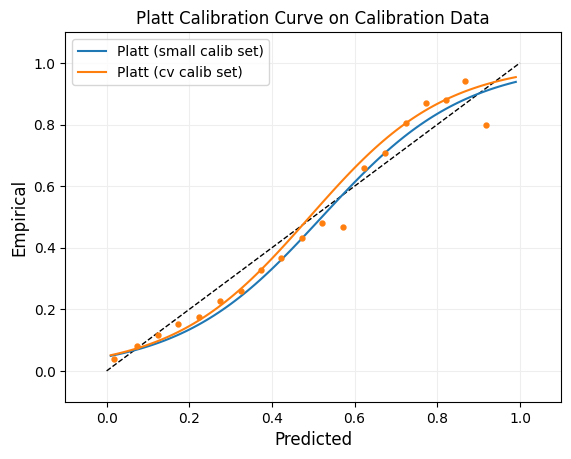

In [67]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (small calib set)')
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (cv calib set)')
plt.title('Platt Calibration Curve on Calibration Data');
plt.legend();

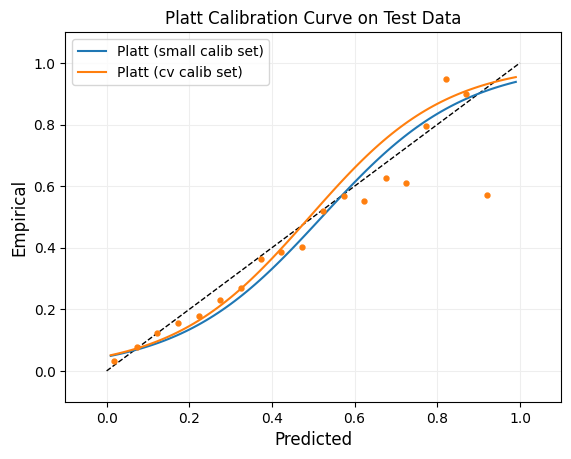

In [68]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (small calib set)')
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (cv calib set)')
plt.title('Platt Calibration Curve on Test Data');
plt.legend();

We see that the two curves are not very different.  Since Platt scaling fits just two parameters, the function does not change much with more data.  The upside is that you don't need a lot of calibration data to use Platt scaling!

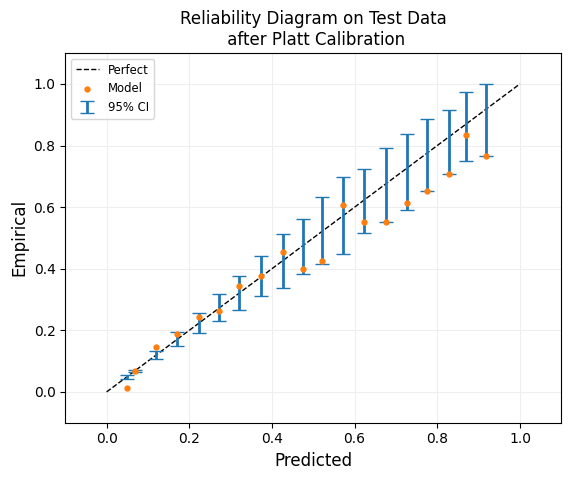

In [69]:
mli.plot_reliability_diagram(y_test_1, testset_platt_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

<br>

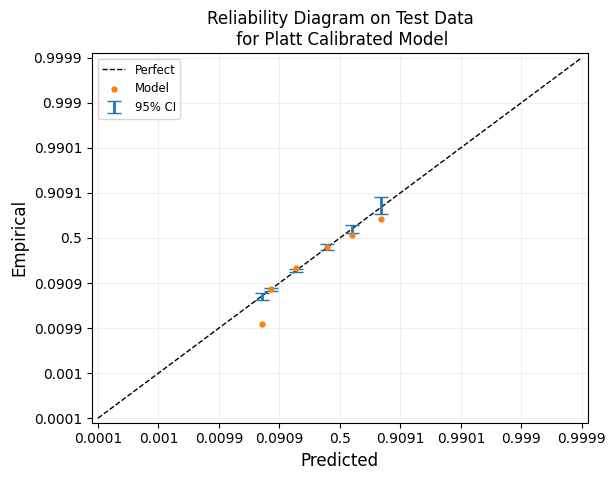

In [70]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_platt_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Platt Calibrated Model');

In [71]:
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Platt calibrated log_loss = 0.29775410395666785
Uncalibrated log_loss = 0.3124065935918772


Having extra data did not really change our results



### Isotonic with CV data

In [72]:
iso_cv = IsotonicRegression(out_of_bounds = 'clip')
iso_cv.fit(cv_preds_train1, y_train_1)

IsotonicRegression(out_of_bounds='clip')

In [73]:
testset_iso_probs_cv = iso_cv.predict(testset_preds_uncalib_1)

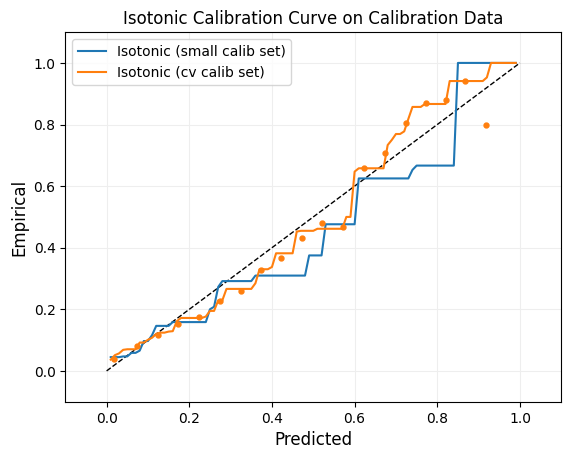

In [74]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic (small calib set)');
plt.plot(tvec, iso_cv.predict(tvec), label='Isotonic (cv calib set)');
plt.title('Isotonic Calibration Curve on Calibration Data');
plt.legend();

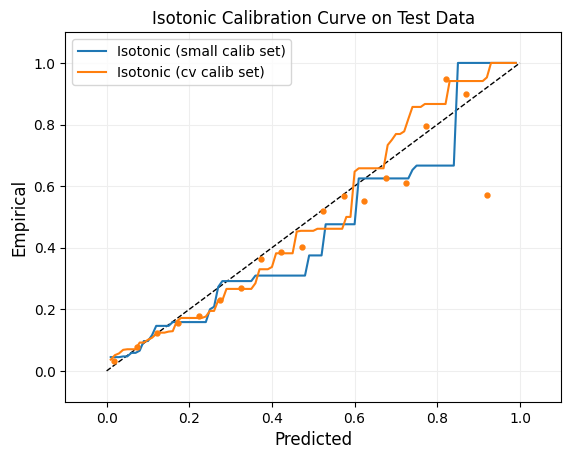

In [75]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic (small calib set)');
plt.plot(tvec, iso_cv.predict(tvec), label='Isotonic (cv calib set)');
plt.title('Isotonic Calibration Curve on Test Data');
plt.legend();

We see above, that with more data, the Isotonic regression fits the test data better, particularly in the middle of the range.  Qualitatively, the vertical jumps are less extreme.

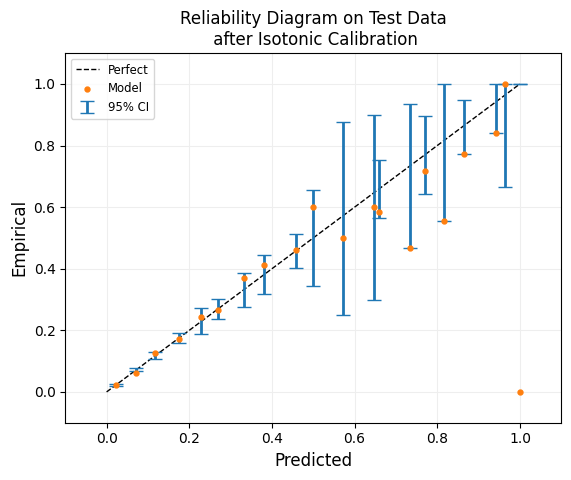

In [76]:
mli.plot_reliability_diagram(y_test_1, testset_iso_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration');

The isotonic regression appears to have benefitted from the extra calibration data.

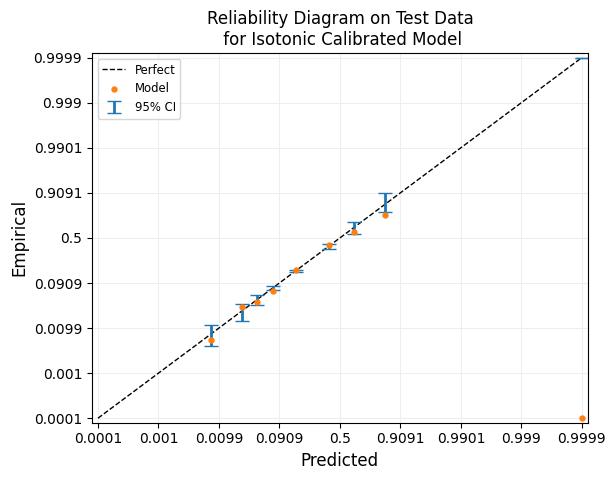

In [77]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_iso_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Isotonic Calibrated Model');

In [78]:
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Isotonic calibrated log_loss = 0.29568290296351485
Platt calibrated log_loss = 0.29775410395666785
Uncalibrated log_loss = 0.3124065935918772


With the larger data set we see much better performance from isotonic regression.

### Beta with CV data

In [79]:
# Fit three-parameter beta calibration
bc_cv = BetaCalibration()
bc_cv.fit(cv_preds_train1, y_train_1)


BetaCalibration()

In [80]:
testset_bc_probs_cv = bc_cv.predict(testset_preds_uncalib_1)


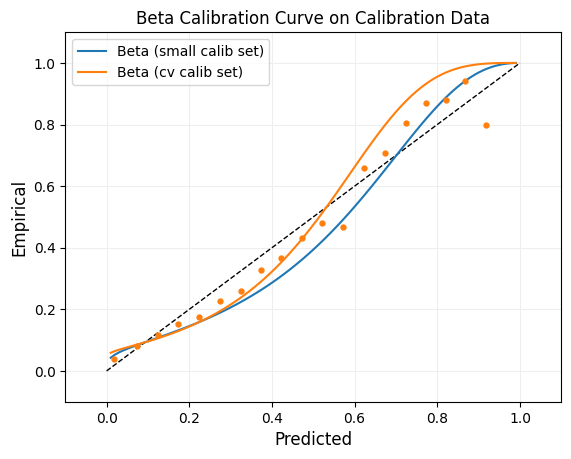

In [81]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec), label='Beta (small calib set)')
plt.plot(tvec, bc_cv.predict(tvec), label='Beta (cv calib set)')
plt.title('Beta Calibration Curve on Calibration Data');
plt.legend();

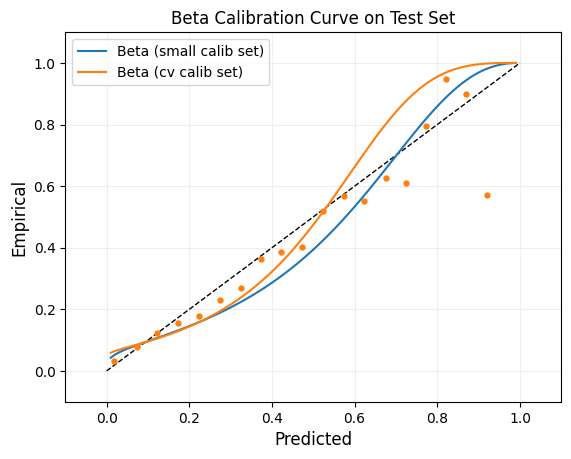

In [82]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec), label='Beta (small calib set)')
plt.plot(tvec, bc_cv.predict(tvec), label='Beta (cv calib set)')
plt.title('Beta Calibration Curve on Test Set');
plt.legend();

We see a small difference in the curves, but not a huge change from having 3K points vs 45K points to learn from

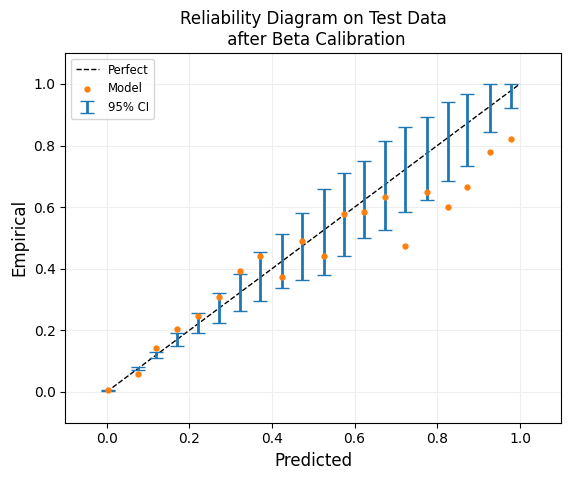

In [83]:
mli.plot_reliability_diagram(y_test_1, testset_bc_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');

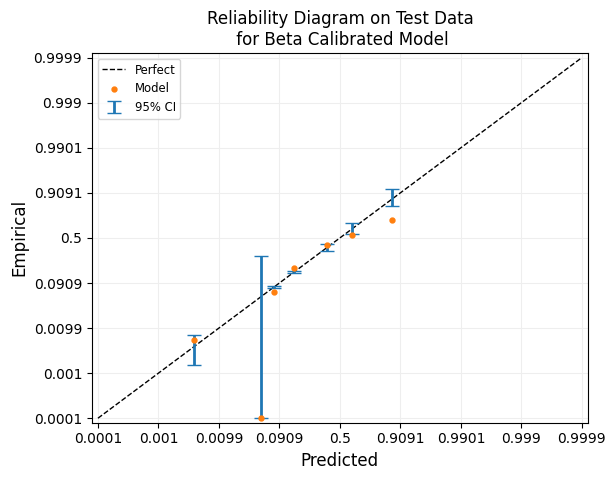

In [84]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_bc_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Beta Calibrated Model');

Not much of a change from the smaller calib set

In [85]:
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs_cv)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Beta calibrated log_loss = 0.296893459431626
Isotonic calibrated log_loss = 0.29568290296351485
Platt calibrated log_loss = 0.29775410395666785
Uncalibrated log_loss = 0.3124065935918772


Now, Beta calibration does slightly better than Platt scaling.  Isotonic has improved.

### SplineCalib with CV data

In [86]:
splinecalib_cv = mli.SplineCalib()
splinecalib_cv.fit(cv_preds_train, y_train_1)

In [87]:
testset_splinecalib_probs_cv = splinecalib_cv.predict(testset_preds_uncalib_1)

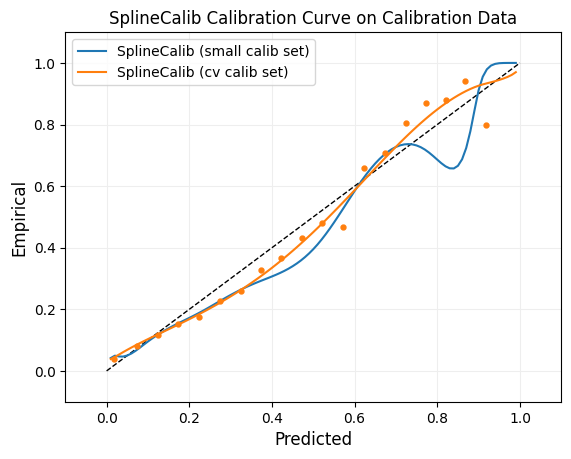

In [88]:
mli.plot_reliability_diagram(y_train_1, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec), label='SplineCalib (small calib set)')
plt.plot(tvec, splinecalib_cv.predict(tvec), label='SplineCalib (cv calib set)')
plt.title('SplineCalib Calibration Curve on Calibration Data');
plt.legend();

With the larger data set, the calibration curve is now close to the line y=x

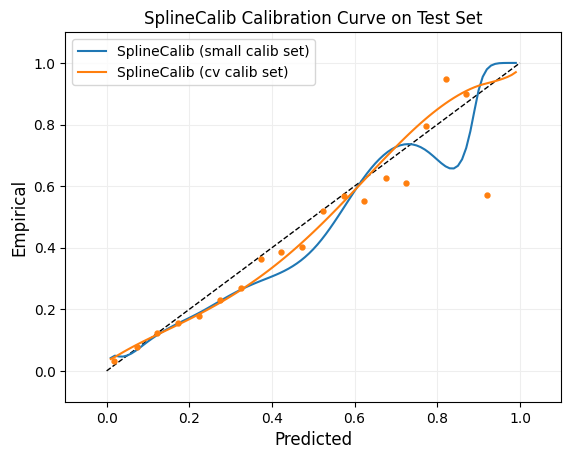

In [89]:
mli.plot_reliability_diagram(y_test_1, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec), label='SplineCalib (small calib set)')
plt.plot(tvec, splinecalib_cv.predict(tvec), label='SplineCalib (cv calib set)')
plt.title('SplineCalib Calibration Curve on Test Set');
plt.legend();

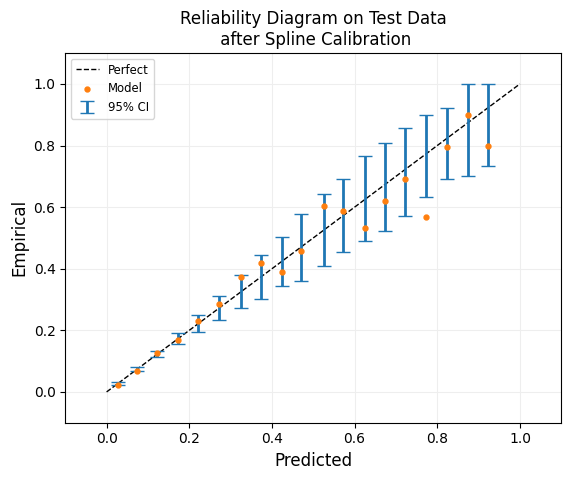

In [90]:
mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Spline Calibration');

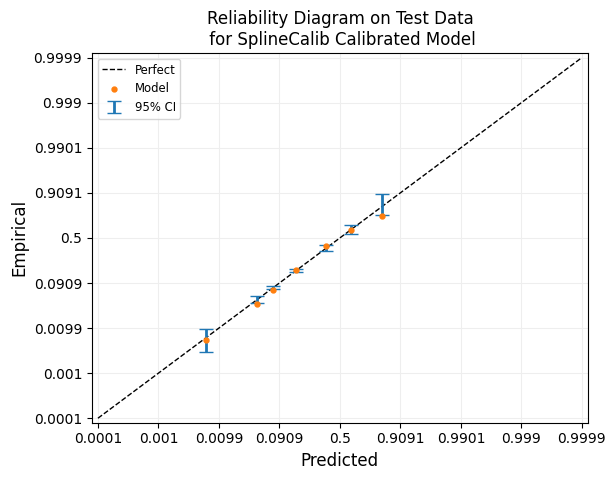

In [91]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_test_1, testset_splinecalib_probs_cv, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for SplineCalib Calibrated Model');

The points are very close to the line y=x

In [92]:
print('Spline calibrated log_loss = {}'.format(log_loss(y_test_1, testset_splinecalib_probs_cv)))
print('Beta calibrated log_loss = {}'.format(log_loss(y_test_1, testset_bc_probs_cv)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated log_loss = 0.293254132812126
Beta calibrated log_loss = 0.296893459431626
Isotonic calibrated log_loss = 0.29568290296351485
Platt calibrated log_loss = 0.29775410395666785
Uncalibrated log_loss = 0.3124065935918772


In [93]:
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_splinecalib_probs_cv)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_bc_probs_cv)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_iso_probs_cv)))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_platt_probs_cv)))
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(y_test_1, testset_preds_uncalib_1)))

Spline calibrated Brier Score = 0.08453641211047308
Beta calibrated Brier Score = 0.08517675513513251
Isotonic calibrated Brier Score = 0.08476272992536248
Platt calibrated Brier Score = 0.08502257395376395
Uncalibrated Brier Score = 0.0848498497268394


## Your Turn


- Use the `mli.cv_predictions` functions on `rfmodel2` to create a cross-validated set on which to fit your calibration.

- Then calibrate `rfmodel2` using this set, rather than the separate calibration set.  Compare the results.

- How do the results compare to `rfmodel1`? 

## Extra Credit
- Make a copy of the original notebook.  Change the random state `rs` in cell [5] and then do "Kernel->Restart and Run All".  Observe how the relative performance changes for the different methods both using the calibration set and the cross-validated approach

- Adjust the training and calibration sizes and see how it affects the performances.

### Some things you might notice
- Isotonic Regression can be quite variable - especially with smaller calibration sets.
- Isotonic Regression tends to improve quite a bit as it gets more data
- Beta Calibration tends to beat Platt Scaling (though not always)
- The rankings for log-loss are often not the same as for Brier Score